This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

## import libraries 

In [ ]:
import argparse
import itertools
import multiprocessing
import pathlib
import sys
from multiprocessing import Pool

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import pandas as pd
import skimage
import tifffile
import tqdm
from skimage import io

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd
else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break
sys.path.append(str(root_dir / "utils"))
from arg_parsing_utils import check_for_missing_args, parse_args
from notebook_init_utils import bandicoot_check, init_notebook

root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(pathlib.Path("~/mnt/bandicoot").resolve(), root_dir)

sys.path.append(f"{root_dir}/utils")
from segmentation_decoupling import (
    extract_unique_masks,
    get_combinations_of_indices,
    get_number_of_unique_labels,
    merge_sets_df,
    reassemble_each_mask,
)

## parse args and set paths

In [ ]:
if not in_notebook:
    args = parse_args()
    window_size = args["window_size"]

    well_fov = args["well_fov"]
    patient = args["patient"]
    compartment = args["compartment"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        compartment=compartment,
        window_size=window_size,
    )

else:
    print("Running in a notebook")
    print("Running in a notebook")
    well_fov = "C2-1"
    compartment = "organoid"
    window_size = 4
    patient = "NF0014_T1"

input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/zstack_images/{well_fov}"
).resolve(strict=True)

mask_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/segmentation_masks/{well_fov}"
).resolve()
mask_path.mkdir(exist_ok=True, parents=True)

if compartment == "nuclei":
    reconstruction_dict_path = pathlib.Path(
        mask_path / "nuclei_reconstruction_dict.npy"
    ).resolve(strict=True)
    mask_output_file_path = pathlib.Path(
        mask_path / "nuclei_masks_decoupled.tiff"
    ).resolve()
    distance_threshold = 10
elif compartment == "cell":
    reconstruction_dict_path = pathlib.Path(
        mask_path / "cell_reconstruction_dict.npy"
    ).resolve(strict=True)
    mask_output_file_path = pathlib.Path(
        mask_path / "cell_masks_decoupled.tiff"
    ).resolve()
    distance_threshold = 10
elif compartment == "organoid":
    reconstruction_dict_path = pathlib.Path(
        mask_path / "organoid_reconstruction_dict.npy"
    ).resolve(strict=True)
    mask_output_file_path = pathlib.Path(
        mask_path / "organoid_masks_decoupled.tiff"
    ).resolve()
    distance_threshold = 40
else:
    raise ValueError(
        "Invalid compartment, please choose 'nuclei', 'cell', or 'organoid'"
    )

Running in a notebook
Running in a notebook


## Set up images, paths and functions

In [3]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]
# get the nuclei image
for f in files:
    if compartment == "nuclei" and "405" in f:
        imgs = io.imread(f)
    elif compartment == "cell" and "555" in f:
        imgs = io.imread(f)
    elif compartment == "organoid" and "488" in f:
        imgs = io.imread(f)
imgs = np.array(imgs)
original_imgs = imgs.copy()
original_img_shape = imgs.shape
original_z_slice_count = len(imgs)
print("number of z slices in the original image:", original_z_slice_count)

number of z slices in the original image: 7


In [4]:
reconstruction_dict = np.load(reconstruction_dict_path, allow_pickle=True).item()

## Reverse the sliding window max projection

In [5]:
masks_dict = {}
for zslice, arrays in tqdm.tqdm(enumerate(reconstruction_dict)):
    df = extract_unique_masks(reconstruction_dict[zslice])
    merged_df = get_combinations_of_indices(df, distance_threshold=distance_threshold)
    # combine dfs for each window index
    # for window_index in range(window_size + 1):
    merged_df = merge_sets_df(merged_df)
    if not merged_df.empty:
        merged_df.loc[:, "slice"] = zslice
        reassembled_masks = reassemble_each_mask(
            merged_df, original_img_shape=original_imgs.shape
        )
        masks_dict[zslice] = reassembled_masks
    else:
        print(f"Warning: merged_df is empty for zslice {zslice}")
        masks_dict[zslice] = reconstruction_dict[zslice][0]

2it [00:00, 18.78it/s]

4it [00:00, 12.13it/s]

7it [00:00, 15.19it/s]

In [6]:
# convert the masks_dict to a numpy array
masks = np.zeros(
    (original_z_slice_count, original_img_shape[1], original_img_shape[2]),
    dtype=np.uint16,
)
masks = np.array(list(masks_dict.values()))
if get_number_of_unique_labels(masks) > 255:
    masks = masks.astype(np.uint16)
else:
    masks = masks.astype(np.uint8)

# save the masks
tifffile.imwrite(mask_output_file_path, masks)

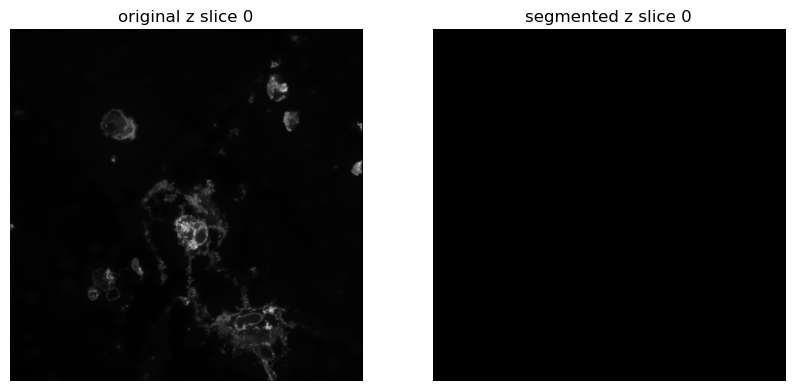

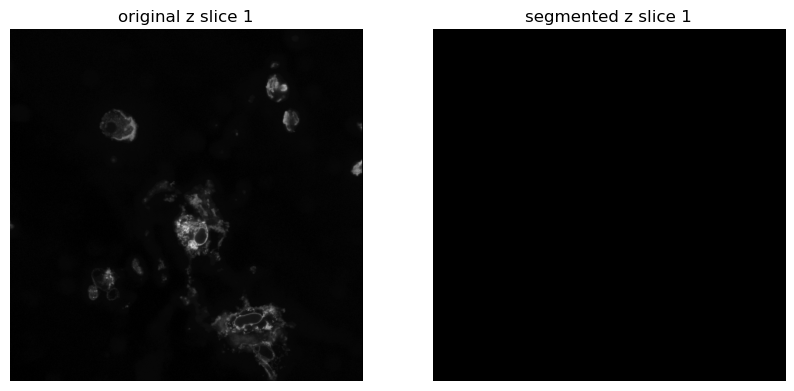

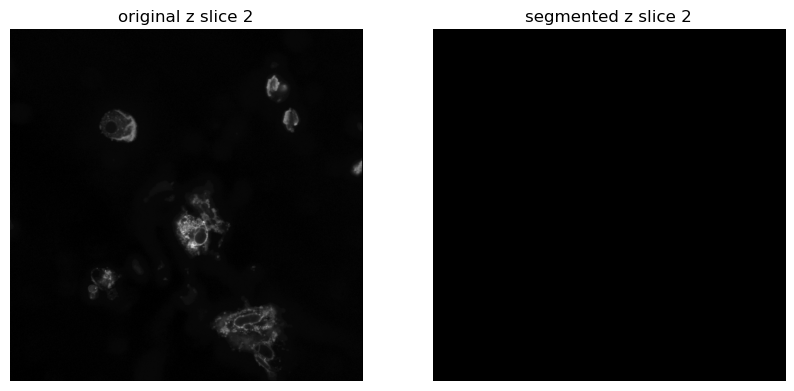

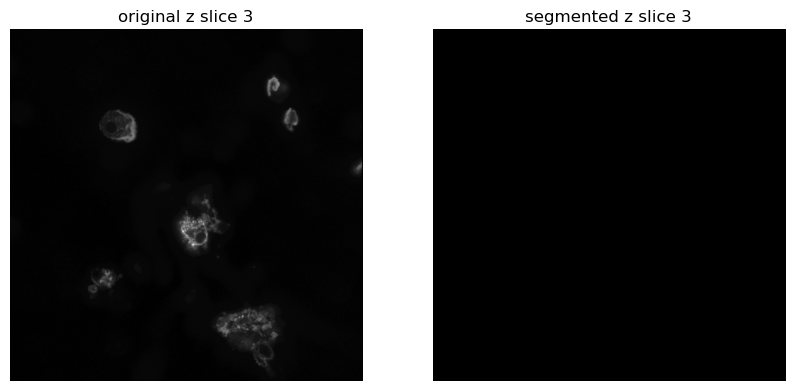

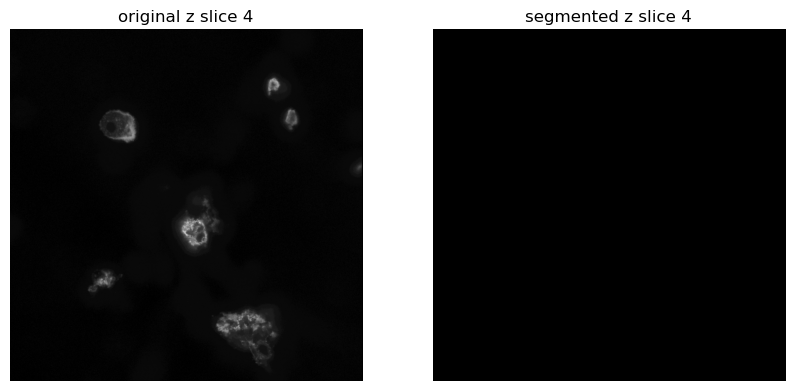

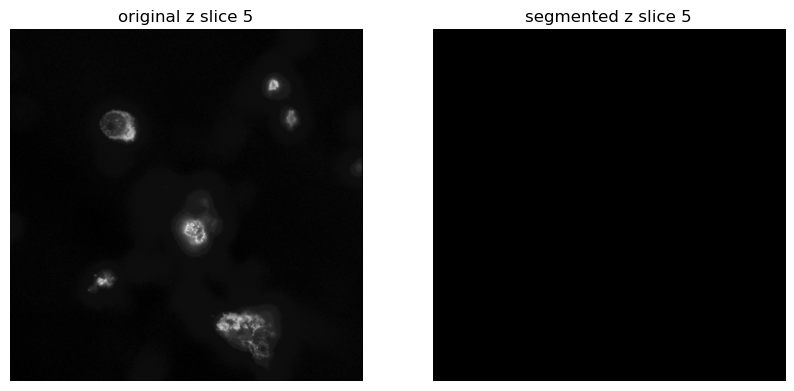

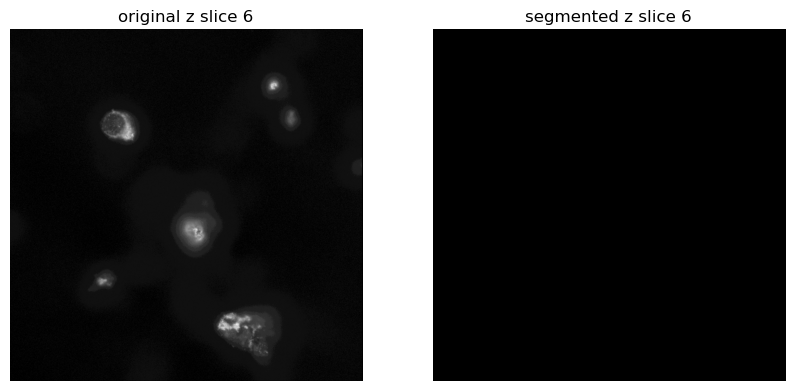

In [7]:
if in_notebook:
    for zslice in range(masks.shape[0]):
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(original_imgs[zslice], cmap="gray")
        plt.title(f"original z slice {zslice}")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(masks[zslice], cmap="nipy_spectral")
        plt.title(f"segmented z slice {zslice}")
        plt.axis("off")
        plt.show()